In [1]:
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

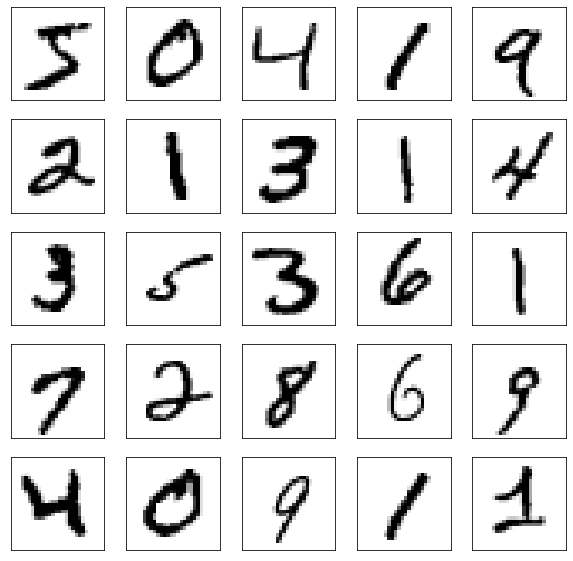

In [32]:
(img,_),(_,_) =  tf.keras.datasets.mnist.load_data() 
img=img.astype(np.float32)/255.0
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[i], cmap=plt.cm.binary)
plt.show()

In [29]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data() 
#X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data() 
#Uncomment second line and comment the first to run the code for fashion mnist dataset

In [5]:
m = X_train.shape[0]
n = X_train.shape[1]

In [6]:
X_train = X_train.reshape(m, 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
X_train.shape

(60000, 28, 28, 1)

In [8]:
BATCH_SIZE = 256

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset= dataset.shuffle(m).batch(BATCH_SIZE)

In [30]:
def G():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #Upsampling
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #Final image is sized 28x28x1
    return model

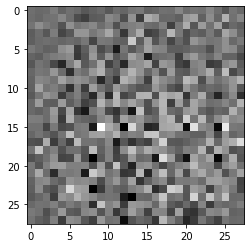

In [11]:
generator = G()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False) 
plt.imshow(generated_image[0, :, :, 0], cmap='gray') #Image generated with untrained generator

In [12]:
def D(): #CNN based classifier
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation='sigmoid')) #Single output
    return model

In [13]:
discriminator = D()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4998464]], shape=(1, 1), dtype=float32)


In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #helper function

In [15]:
def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
G_opt = tf.keras.optimizers.Adam(1e-4)
D_opt = tf.keras.optimizers.Adam(1e-4) #Seperate optimizers because we train both networks seperately

In [26]:
z = 100
num_examples_to_generate = 25 
seed = tf.random.normal([num_examples_to_generate, z])

In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, z])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = G_loss(fake_output)
      disc_loss = D_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    G_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    D_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
def train(dataset, epochs,test_input,model):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)
    display.clear_output(wait=True)
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    if epoch + 1 % 10 == 0:
      plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    print ('Image after epoch {}'.format(epoch + 1))

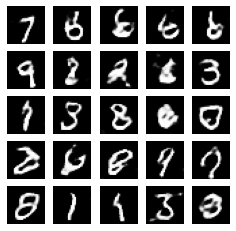

Image after epoch 50


In [28]:
train(dataset, 50,seed,generator)